<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Einen-Bilddatensatz-vorbereiten" data-toc-modified-id="Einen-Bilddatensatz-vorbereiten-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Einen Bilddatensatz vorbereiten</a></span></li><li><span><a href="#Eine-Bilddatensatzklasse-schreiben" data-toc-modified-id="Eine-Bilddatensatzklasse-schreiben-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Eine Bilddatensatzklasse schreiben</a></span></li><li><span><a href="#Testen-der-Bilddatensatzklasse" data-toc-modified-id="Testen-der-Bilddatensatzklasse-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testen der Bilddatensatzklasse</a></span></li><li><span><a href="#Auslagern-der-Bildklasse-in-eine-Datei" data-toc-modified-id="Auslagern-der-Bildklasse-in-eine-Datei-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Auslagern der Bildklasse in eine Datei</a></span></li></ul></div>

# Einen Bilddatensatz vorbereiten

Wir wollen ein CNN als Klassifikator für ein binäres Klassifikationsproblem bauen.

Das CNN soll entscheiden: handelt es sich um ein Bild, das ein Fahrrad zeigt oder ein Auto?

Dazu benötigen wir einen entsprechenden Datensatz.

Der Bilddatensatz sollte dann in folgende Verzeichnisse aufgeteilt sein:

    data
        train
            car
            bike
        test
            car
            bike

# Eine Bilddatensatzklasse schreiben

In [5]:
import os
from os import listdir
from os.path import isdir, isfile, join
import cv2
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

  
class bilddatensatz:
    
    #
    # Geht alle Unterverzeichniss des angegebenen
    # Wurzelverzeichnisses durch und
    # generiert eine Liste der Form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder, img_size, inputs_fuer_VGG16=False):
        
        self.img_size = img_size
        
        self.inputs_fuer_VGG16 = inputs_fuer_VGG16
        
        self.all_training_items = []
       
        self.class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Unter dem Verzeichnis\n\t", root_folder,
              "\nhabe ich folgende Unterordner/Klassen gefunden:")
        print(self.class_names)
        
        self.nr_classes = len(self.class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(self.class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name)
                 if isfile(join(subfolder_name, f))]
            
            print("{} Dateien im Unterverzeicnis {}".format(len(filenames),
                                                     subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename,
                     class_id,
                     class_name,
                     teacher_vec] )
        
        self.nr_images = len(self.all_training_items)
        print("Insgesamt sind {} Bilder verfügbar".format(self.nr_images))
        
        print("Hier die ersten 3 Einträge:")
        print(self.all_training_items[:3])
        
    
    
    def lade_bild(self, absolute_filename):
        """
        Lade ein Bild aus der angegebenen Datei
        und mache es (Farbkanal-spezifisch) Mittelwertfrei
        """
        
        img = cv2.imread(absolute_filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                
        img = cv2.resize(img,
                         self.img_size,
                         interpolation=cv2.INTER_AREA)
        
        if self.inputs_fuer_VGG16:                    
            x = img.astype(float)
            x = np.expand_dims(x, axis=0)
            #print("x has shape", x.shape)                
            #print("x has mean", np.mean(x))        
            # From the VGG paper:
            # "The only pre-processing we do is subtracting the mean RGB value,
            # computed on the training set, from each pixel."
            #
            # see imagenet_utils.py
            #
            x = preprocess_input(x)
            #print("x has mean", np.mean(x))   
            img_preprocessed = x.reshape((224,224,3))
        else:            
            img_preprocessed = img * (1.0 / 255.0)
        
        return img, img_preprocessed
        
        
       
    def hole_bild_per_index(self, idx):
        """
        Gebe das Bild aus dem Datensatz
        mit dem Index idx zurück.
        """
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        img, img_preprocessed = self.lade_bild(image_filename)
        
        return img, img_preprocessed, \
               class_id, class_name, teacher_vec
    
    
    def hole_irgendein_bild(self):        
        """
        Gebe ein zufälliges Bild zurück
        """
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.hole_bild_per_index( rnd_idx )

# Testen der Bilddatensatzklasse

In [1]:
train_folder = r"V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train"
bd = bilddatensatz( train_folder, (100,100) )

NameError: name 'bilddatensatz' is not defined

<class 'numpy.ndarray'>
(100, 100, 3)
0
bikes
[ 1.  0.]


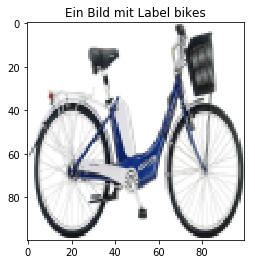

In [7]:
import matplotlib.pyplot as plt

img, img_processed, class_id, class_name, teacher_vec = \
    bd.hole_irgendein_bild()
 
print(type(img))
print(img.shape)
print(class_id)
print(class_name)
print(teacher_vec)

plt.imshow(img)
plt.title("Ein Bild mit Label {}".format(class_name))
plt.show()


# Auslagern der Bildklasse in eine Datei

Den Kernel nun neu starten im Jupyter Notebook, damit der Python Kernel noch keine `bilddatensatz` Klasse kennt!

In [1]:
import sys
sys.path.append(r"..\helferlein")

In [2]:
sys.path

['',
 'C:\\Users\\Juergen Brauer\\AppData\\Local\\conda\\conda\\envs\\bvkurs\\python36.zip',
 'C:\\Users\\Juergen Brauer\\AppData\\Local\\conda\\conda\\envs\\bvkurs\\DLLs',
 'C:\\Users\\Juergen Brauer\\AppData\\Local\\conda\\conda\\envs\\bvkurs\\lib',
 'C:\\Users\\Juergen Brauer\\AppData\\Local\\conda\\conda\\envs\\bvkurs',
 'C:\\Users\\Juergen Brauer\\AppData\\Local\\conda\\conda\\envs\\bvkurs\\lib\\site-packages',
 'C:\\Users\\Juergen Brauer\\AppData\\Local\\conda\\conda\\envs\\bvkurs\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Juergen Brauer\\.ipython',
 '..\\helferlein']

In [3]:
from bilddatensatz import bilddatensatz

Using TensorFlow backend.


In [4]:
train_folder = r"V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train"
bildgroesse = (100,100)
bd = bilddatensatz( train_folder, bildgroesse )

!!!
Unter dem Verzeichnis
	 V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train 
habe ich folgende Unterordner/Klassen gefunden:
['bikes', 'cars']
1000 Dateien im Unterverzeicnis V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train/bikes/
1000 Dateien im Unterverzeicnis V:\01_job\12_datasets\01_imagenet_cars_vs_bikes\train/cars/
Insgesamt sind 2000 Bilder verfügbar
Hier die ersten 3 Einträge:
[['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0001.JPEG', 0, 'bikes', array([ 1.,  0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0002.JPEG', 0, 'bikes', array([ 1.,  0.])], ['V:\\01_job\\12_datasets\\01_imagenet_cars_vs_bikes\\train/bikes/0003.JPEG', 0, 'bikes', array([ 1.,  0.])]]


<class 'numpy.ndarray'>
(100, 100, 3)
0
bikes
[ 1.  0.]


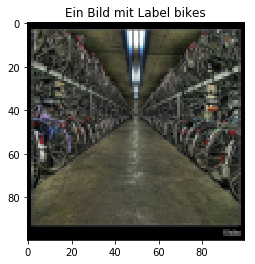

In [9]:
import matplotlib.pyplot as plt

img, img_processed, class_id, class_name, teacher_vec = \
    bd.hole_irgendein_bild()
 
print(type(img))
print(img.shape)
print(class_id)
print(class_name)
print(teacher_vec)

plt.imshow(img)
plt.title("Ein Bild mit Label {}".format(class_name))
plt.show()